### Data Cleaning and Preparation

## Load data (file uploaded in google drive)

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

file_path = '/content/drive/My Drive/reddit_food_delivery_sentiments.csv' #file path in google drive
df = pd.read_csv(file_path)
df.head()


,title,text,comments,date,score,num_comments,created_utc,subreddit,keyword,url
0,Is this normal?,Bought the Popcorn Chicken+Fries+Lemonade from...,Yeah never buying from that restaurant or what...,26/4/2025,227,88.0,1745675485,malaysia,foodpanda,https://i.redd.it/xz7e8glgp6xe1.png
1,Foodpanda Bicycle Rider Question,"Greetings all,\n\nI am looking for specific in...",Hi I used to do foodpanda walker during mco. ...,14/4/2025,0,2.0,1744617428,malaysia,foodpanda,https://www.reddit.com/r/malaysia/comments/1jy...
2,Foodpanda wants you to BEG for refunds,I know there are still a lot of Foodpanda user...,"Stop using foodpanda, shoppeefood is currently...",30/3/2025,20,42.0,1743301789,malaysia,foodpanda,https://www.reddit.com/r/malaysia/comments/1jn...
3,Cancelled my order on FoodPanda and Still didn...,NaN,Pretty sure this falls under KPDNHEP authority...,27/2/2025,30,13.0,1740625211,malaysia,foodpanda,https://i.redd.it/opdl0osaklle1.png
4,Foodpanda vs grab vs shopeefood,NaN,using all 3.\n\nshopeefood - when wanna buy fr...,21/1/2025,0,1.0,1737485781,malaysia,foodpanda,/r/MalaysianFood/comments/1i6l1e4/foodpanda_vs...


## Remove Dupicates and Combine Text into Column




In [3]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Drop rows with no useful text
df.dropna(subset=['title', 'text', 'comments'], how='all', inplace=True)

# Combine all relevant text into a single column
df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('') + ' ' + df['comments'].fillna('')


## Filter Irrelevant Posts

In [4]:
import re

platform_keywords = ['foodpanda', 'grabfood', 'shopeefood', 'food panda', 'grab food', 'shopee food', 'shoppee']
ofd_keywords = [
    'order', 'delivery', 'delivered', 'delivering', 'food', 'meal', 'restaurant', 'kitchen', 'menu',
    'driver', 'rider', 'tip', 'late', 'slow', 'cold', 'refund', 'app', 'voucher', 'promo',
    'cart', 'checkout', 'paid', 'receipt', 'packaging', 'status','drink', 'price', 'fee', 'delvery fee',
    'lunch','dinner', 'rm', 'order', 'orders', 'spend'
]

def is_ofd_post(text):

    text_lower = text.lower()

    # Match platform keywords with word boundaries
    platform_match = any(re.search(rf'\b{re.escape(p)}\b', text_lower) for p in platform_keywords)

    # Count how many ofd-related keywords are found
    context_matches = sum(
        1 for w in ofd_keywords if re.search(rf'\b{re.escape(w)}\b', text_lower)
    )

    # Require at least 5 keywords for OFD context
    context_match = context_matches >= 5

    return platform_match and context_match

# Apply to your DataFrame
df['ofdcontext'] = df['content'].apply(is_ofd_post)

# Filter only relevant posts
df_ofd = df[df['ofdcontext'] == True].copy()

# Drop the context flag if not needed anymore
df_ofd.drop(columns=['ofdcontext'], inplace=True)

# Remove duplicate rows based on content column
df_ofd = df_ofd.drop_duplicates(subset='content')

# Save filtered dataframe
df_ofd[['content']].to_csv('OFD_filtered.csv', index=False)



## Language Translation (Malay to English)
deBERTa works best with English

In [5]:
!pip install deep-translator langdetect
from deep_translator import GoogleTranslator
from langdetect import detect
import re

def smart_translate(text):
    if not isinstance(text, str):
        return text  # return as is if not a string

    try:
        # Split text into sentences using basic punctuation
        sentences = re.split(r'(?<=[.!?]) +', text)
        translated_sentences = []

        for sentence in sentences:
            # Only translate if language detected is not English
            try:
                lang = detect(sentence)
                if lang != 'en':
                    translated = GoogleTranslator(source='auto', target='en').translate(sentence)
                    translated_sentences.append(translated)
                else:
                    translated_sentences.append(sentence)
            except:
                # If detection fails, keep original sentence
                translated_sentences.append(sentence)

        return ' '.join(translated_sentences)

    except Exception as e:
        print(f"⚠️ Translation error: {e}")
        return text

# Warning: this can be slow and rate-limited
df_ofd['translated'] = df_ofd['content'].apply(smart_translate)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.5 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=fd5bad7b7f1ec9f05edb283208beead23b5adea843990b3213937e604e9a743d
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [6]:

# Save just the translated posts
df_ofd[['translated']].to_csv('OFD_translated.csv', index=False)
df_ofd['translated'].head (10)


,translated
2,Foodpanda wants you to BEG for refunds I know ...
3,Cancelled my order on FoodPanda and Still didn...
4,Foodpanda vs grab vs shopeefood using all 3.\...
5,"Foodpanda rider spilled drink, no refund Order..."
7,foodpanda - fake 5 star ratings just wanted to...
10,Diner furious with Foodpanda for only giving a...
12,GrabFood customer service is so bad I’ve been ...
14,Beware of the TNG RM5 for RM120 Voucher Pack S...
15,foodpanda.... are you serious right neow????? ...
16,We have something new to boycott again : Foodp...


## Data Cleaning (Based on research by Arpita et al. (2020))

In [7]:
!pip install nltk
!pip install emoji
import re
import emoji
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):

    text = re.sub(r'@\w+', '', text)  # Remove @username
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = emoji.demojize(text)  # Decode emojis into words
    text = text.strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text


df_ofd['cleaned_text'] = df_ofd['translated'].apply(clean_text)
df_ofd[['cleaned_text']].to_csv('OFD_cleaned.csv', index=False)

df_ofd['cleaned_text'].head(10)
df_ofd.head(10)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 13.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,title,text,comments,date,score,num_comments,created_utc,subreddit,keyword,url,content,translated,cleaned_text
2,Foodpanda wants you to BEG for refunds,I know there are still a lot of Foodpanda user...,"Stop using foodpanda, shoppeefood is currently...",30/3/2025,20,42.0,1743301789,malaysia,foodpanda,https://www.reddit.com/r/malaysia/comments/1jn...,Foodpanda wants you to BEG for refunds I know ...,Foodpanda wants you to BEG for refunds I know ...,foodpanda wants beg refunds know still lot foo...
3,Cancelled my order on FoodPanda and Still didn...,NaN,Pretty sure this falls under KPDNHEP authority...,27/2/2025,30,13.0,1740625211,malaysia,foodpanda,https://i.redd.it/opdl0osaklle1.png,Cancelled my order on FoodPanda and Still didn...,Cancelled my order on FoodPanda and Still didn...,cancelled order foodpanda still didnt get refu...
4,Foodpanda vs grab vs shopeefood,NaN,using all 3.\n\nshopeefood - when wanna buy fr...,21/1/2025,0,1.0,1737485781,malaysia,foodpanda,/r/MalaysianFood/comments/1i6l1e4/foodpanda_vs...,Foodpanda vs grab vs shopeefood using all 3.\...,Foodpanda vs grab vs shopeefood using all 3.\...,foodpanda vs grab vs shopeefood using shopeefo...
5,"Foodpanda rider spilled drink, no refund",Ordered two drinks from foodpanda. The foodpan...,Rise dispute again || Keep complaining and don...,6/1/2025,164,50.0,1736162476,malaysia,foodpanda,https://www.reddit.com/gallery/1huwu3d,"Foodpanda rider spilled drink, no refund Order...","Foodpanda rider spilled drink, no refund Order...",foodpanda rider spilled drink refund ordered t...
7,foodpanda - fake 5 star ratings,just wanted to put this out here. cos fuck foo...,"Rule #14405, never trust a star ratings on the...",13/9/2024,15,9.0,1726223537,malaysia,foodpanda,https://www.reddit.com/r/malaysia/comments/1ff...,foodpanda - fake 5 star ratings just wanted to...,foodpanda - fake 5 star ratings just wanted to...,foodpanda fake star ratings wanted put cos fuc...
10,Diner furious with Foodpanda for only giving a...,NaN,Users often report submissions from this site ...,29/8/2024,20,3.0,1724901691,malaysia,foodpanda,https://focusmalaysia.my/diner-furious-with-fo...,Diner furious with Foodpanda for only giving a...,Diner furious with Foodpanda for only giving a...,diner furious foodpanda giving automated reply...
12,GrabFood customer service is so bad,I’ve been using grab as my food delivery servi...,I had bad experiences with both apps but Grab ...,26/7/2024,10,13.0,1722014610,malaysia,foodpanda,https://www.reddit.com/r/malaysia/comments/1ec...,GrabFood customer service is so bad I’ve been ...,GrabFood customer service is so bad I’ve been ...,grabfood customer service bad ive using grab f...
14,Beware of the TNG RM5 for RM120 Voucher Pack S...,[Voucherpack\_June\_webbanner.png](https://pre...,You could lodge a complain to KPDN about decep...,19/6/2024,312,37.0,1718768337,malaysia,foodpanda,https://www.reddit.com/r/malaysia/comments/1dj...,Beware of the TNG RM5 for RM120 Voucher Pack S...,Beware of the TNG RM5 for RM120 Voucher Pack S...,beware tng rm rm voucher pack scam voucherpack...
15,foodpanda.... are you serious right neow????? ...,NaN,Wtf??? Max delivery fee ive seen on peak hour ...,14/6/2024,163,87.0,1718356010,malaysia,foodpanda,https://i.redd.it/a3hdp3bn6i6d1.jpeg,foodpanda.... are you serious right neow????? ...,foodpanda.... are you serious right neow????? ...,foodpanda serious right neow im pissed wtf max...
16,We have something new to boycott again : Foodp...,https://preview.redd.it/dhe2r2ahtg4d1.png?widt...,What does food panda have to do with this? Hal...,4/6/2024,0,36.0,1717467816,malaysia,foodpanda,https://www.reddit.com/r/malaysia/comments/1d7...,We have something new to boycott again : Foodp...,We have something new to boycott again : Foodp...,something new boycott foodpanda food panda hal...


###  Load and use a pretrained ABSA model.

## Tokenisation and Import Model from HuggingFace
model source: yangheng/deberta-v3-base-absa-v1.1 (hugging face)

In [8]:
!pip install transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load pretrained ABSA model
model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline
absa_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

Device set to use cuda:0


## Split sentences into respective OFD and labelling

# Install required packages (only need to run once) and libraries

In [9]:
# Required packages
!pip install nltk
!pip install emoji
!pip install transformers

# Python Libraries
import nltk
import re
import emoji
import pandas as pd
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')  # For sentence tokenization


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Define OFD keyword patterns

In [10]:
# OFD keyword patterns
ofd_patterns = {
    'foodpanda': ['foodpanda', 'food panda'],
    'grabfood': ['grabfood', 'grab food', ],
    'shopeefood': ['shopeefood', 'shopee food', 'shoppeefood', 'shoppee food']
}

# Detect OFDs in a full post
def detect_ofds_in_post(text):
    text = text.lower()
    found_ofds = []
    for ofd, keywords in ofd_patterns.items():
        if any(k in text for k in keywords):
            found_ofds.append(ofd)
    return found_ofds


# Create sentence-level dataframe with duplicated OFD labels

In [11]:
# Function for entence-level dataframe with duplicated OFD labels
def expand_sentences_by_ofd(df, text_column='cleaned_text'):
    new_rows = []

    for idx, row in df.iterrows():
        full_text = row[text_column]
        ofds_in_post = detect_ofds_in_post(full_text)

        if not ofds_in_post:
            continue  # Skip if no OFD detected in this post

        # Split into sentences
        sentences = sent_tokenize(full_text)

        # For each sentence, duplicate it for each OFD in the post
        for sent in sentences:
            for ofd in ofds_in_post:
                new_rows.append({
                    'original_post': full_text,
                    'sentence': sent.strip(),
                    'related_ofd': ofd
                })

    return pd.DataFrame(new_rows)


In [12]:
# Apply on cleaned dataset
sentence_df = expand_sentences_by_ofd(df_ofd, text_column='cleaned_text')

# Preview results
sentence_df.head(10)

# Count total number of new sentence entries
print("Total sentences after expansion:", len(sentence_df))



Total sentences after expansion: 162


# Labelling OFD for each post

In [13]:
# Add a column for ABSA target
sentence_df['target'] = sentence_df['related_ofd']

# Format for ABSA pipeline
absa_input = sentence_df[['sentence', 'target']].rename(columns={
    'sentence': 'text',
    'target': 'ofd'
})
absa_input.head(10)
absa_input['ofd'].value_counts()


,count
ofd,
foodpanda,75
grabfood,68
shopeefood,19


In [14]:
# Export labelled file
absa_input.to_csv('OFD_labelled.csv', index=False)

## Create and Run ABSA Predictions

# Redefine aspect keywords

In [15]:
# Defining 5 aspects to focus on
aspect_keywords = {
    'price': ['cheap', 'expensive', 'affordable', 'tax', 'delivery charge', 'fee', 'delivery fee'],
    'delivery time': ['fast', 'slow', 'late', 'early', 'quick', 'on time'],
    'promotion': ['voucher', 'promotion', 'celebration', 'discount', 'reward', 'unlimited'],
    'review': ['good', 'bad', 'worth', 'disappointing', 'uninstall', 'bad service', 'cancel', 'refund', 'experience'],
    'food condition': ['small', 'big', 'proportion', 'spill', 'wrong', 'cold', 'hot', 'stale']
}
aspect_keywords = {k: [word.lower() for word in v] for k, v in aspect_keywords.items()}


# Run ABSA on each row

In [16]:
# Run ABSA on each row in absa_input
results = []

for _, row in absa_input.iterrows():
    sentence = row['text']
    ofd = row['ofd']
    sentence_lower = sentence.lower()

    row_result = {
        'sentence': sentence,
        'related_ofd': ofd
    }

    for aspect, keywords in aspect_keywords.items():
        if any(keyword in sentence_lower for keyword in keywords):
            formatted_text = f"{aspect} aspect of {row['ofd']}: {row['text']}"
            try:
                prediction = absa_pipeline(formatted_text)[0]
                row_result[f"{aspect}_sentiment"] = prediction['label']
                row_result[f"{aspect}_score"] = prediction['score']
            except Exception as e:
                row_result[f"{aspect}_sentiment"] = "error"
                row_result[f"{aspect}_score"] = 0.0
                print(f"⚠️ Error processing: {formatted_text}\n{e}")
        else:
            row_result[f"{aspect}_sentiment"] = "Neutral"
            row_result[f"{aspect}_score"] = 1.0  # Optional: Adjust default score

    results.append(row_result)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


# Create DataFrame from results

In [17]:
# Create DataFrame
absa_df = pd.DataFrame(results)

#  Save and preview
absa_df.to_csv("OFD_absaResult.csv", index=False)
absa_df.head()


,sentence,related_ofd,price_sentiment,price_score,delivery time_sentiment,delivery time_score,promotion_sentiment,promotion_score,review_sentiment,review_score,food condition_sentiment,food condition_score
0,foodpanda wants beg refunds know still lot foo...,foodpanda,Negative,0.951405,Negative,0.952384,Negative,0.952686,Negative,0.951570,Negative,0.950309
1,foodpanda wants beg refunds know still lot foo...,shopeefood,Negative,0.946824,Negative,0.947557,Negative,0.948245,Negative,0.947066,Negative,0.945051
2,cancelled order foodpanda still didnt get refu...,foodpanda,Neutral,1.000000,Negative,0.917631,Neutral,1.000000,Negative,0.894423,Neutral,1.000000
3,foodpanda vs grab vs shopeefood using shopeefo...,foodpanda,Neutral,0.623801,Neutral,1.000000,Neutral,0.823594,Neutral,1.000000,Neutral,1.000000
4,foodpanda vs grab vs shopeefood using shopeefo...,grabfood,Neutral,0.511147,Neutral,1.000000,Neutral,0.798817,Neutral,1.000000,Neutral,1.000000


##  Load the CSV and install required libraries for visualisation testing

In [18]:
!pip install matplotlib seaborn wordcloud

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import numpy as np



In [19]:
# Load the data
absa_df = pd.read_csv("OFD_absaResult.csv")




### General analysis of OFD (Dashboard homepage)

## Number of Posts per OFD

This chart counts how many posts are about Foodpanda, GrabFood, ShopeeFood

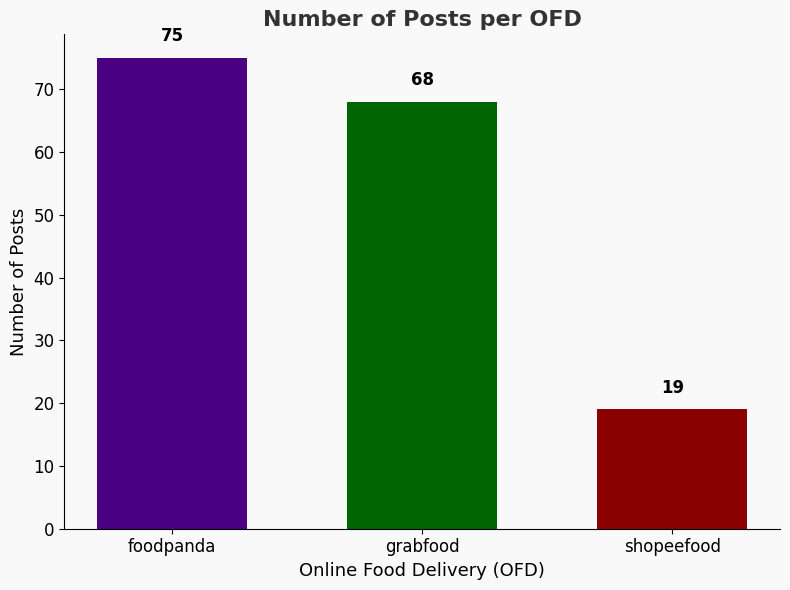

In [20]:
import matplotlib.pyplot as plt

# Use a more elegant, darker color palette
ofd_colors = {
    'foodpanda': '#4B0082',     # dark indigo
    'grabfood': '#006400',      # dark green
    'shopeefood': '#8B0000'     # dark red
}

# Count number of posts per OFD
ofd_counts = absa_df['related_ofd'].value_counts()

# Plot with custom colors
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(ofd_counts.index, ofd_counts.values, color=[ofd_colors[ofd] for ofd in ofd_counts.index], width=0.6)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{int(height)}', ha='center', va='bottom', fontsize=12, weight='bold', color='black')

# Aesthetic styling
ax.set_title('Number of Posts per OFD', fontsize=16, fontweight='bold', color='#333333')
ax.set_xlabel('Online Food Delivery (OFD)', fontsize=13)
ax.set_ylabel('Number of Posts', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_facecolor('#F9F9F9')
fig.patch.set_facecolor('#F9F9F9')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()




## Total Sentiments by Brand (Stacked Bar)

Shows overall sentiment distribution across all brands and total combined

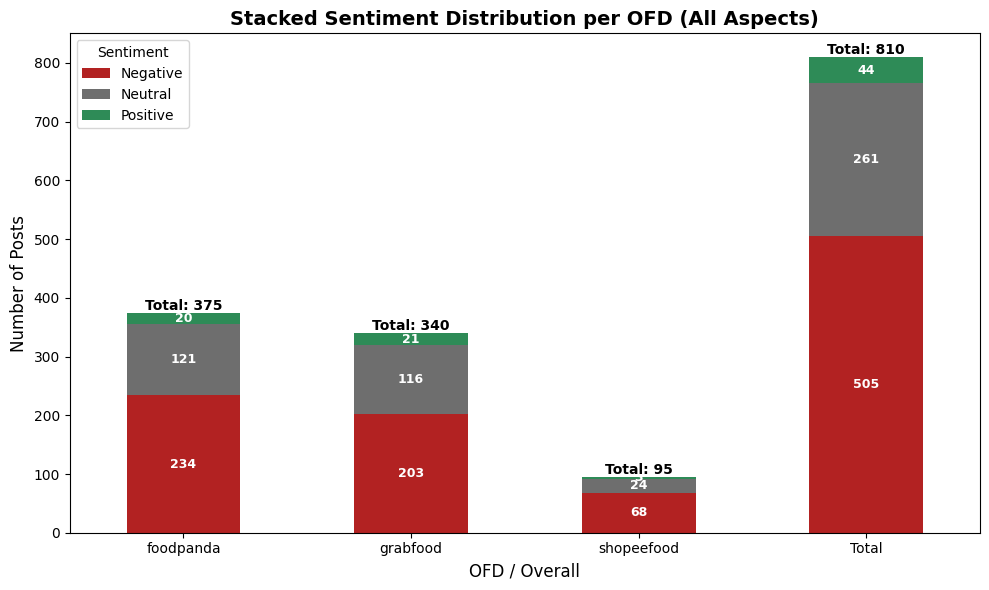

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Elegant color palette (darker)
colors = {'negative': '#B22222', 'neutral': '#6E6E6E', 'positive': '#2E8B57'}

# Combine sentiment columns into a unified format
combined_sentiments = pd.DataFrame()

for col in [
    'price_sentiment',
    'delivery time_sentiment',
    'promotion_sentiment',
    'review_sentiment',
    'food condition_sentiment'
]:
    temp_df = absa_df[['related_ofd', col]].rename(columns={col: 'sentiment'})
    combined_sentiments = pd.concat([combined_sentiments, temp_df])

# Group by OFD and sentiment
summary = combined_sentiments.groupby(['related_ofd', 'sentiment']).size().unstack(fill_value=0)

# Add Total row
summary.loc['Total'] = summary.sum()

# Plot
ax = summary.plot(kind='bar', stacked=True, figsize=(10,6), color=[
    colors['negative'], colors['neutral'], colors['positive']
])

# Add number labels
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fontsize=9, weight='bold')

# Add total posts label on top of each bar
totals = summary.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total + 5, f'Total: {total}', ha='center', fontsize=10, fontweight='bold')

plt.title('Stacked Sentiment Distribution per OFD (All Aspects)', fontsize=14, weight='bold')
plt.xlabel('OFD / Overall', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
plt.tight_layout()
plt.show()



## Pie Charts: Total Sentiment Share for Each Brand

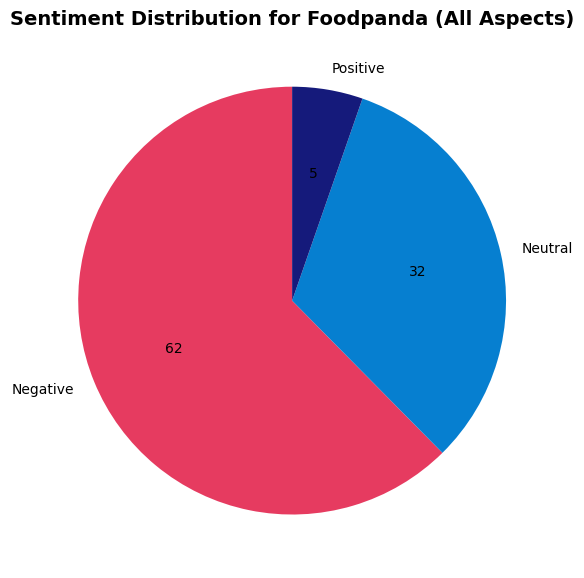

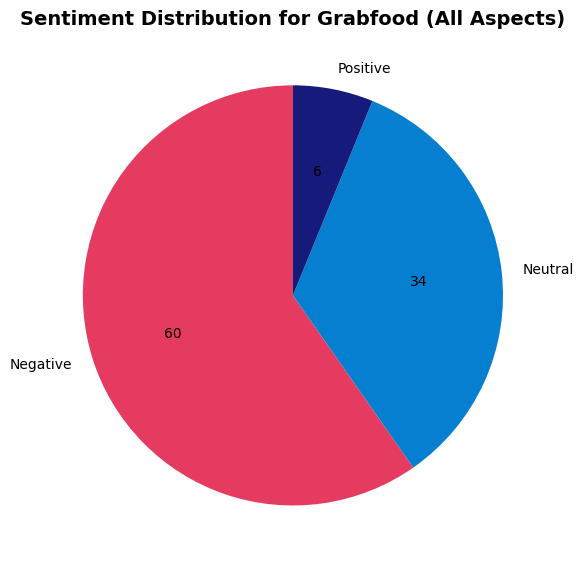

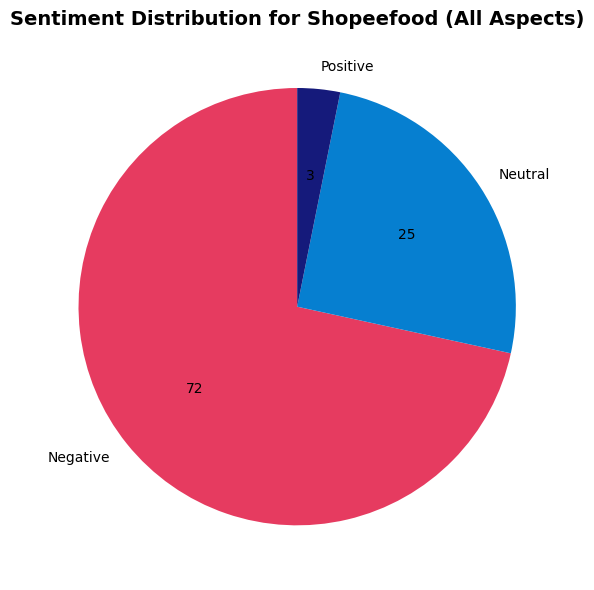

In [22]:
# Elegant palette
pie_colors = ['#E63B60', '#067FD0', '#151A7B']  # dark red, grey, dark green

# Pie chart for each OFD
for ofd in ['foodpanda', 'grabfood', 'shopeefood']:
    sentiments = combined_sentiments[combined_sentiments['related_ofd'] == ofd]['sentiment'].value_counts()

    plt.figure(figsize=(6,6))
    plt.pie(
        sentiments,
        labels=sentiments.index,
        autopct='%1.0f',  # show count instead of %
        startangle=90,
        colors=pie_colors
    )
    plt.title(f'Sentiment Distribution for {ofd.capitalize()} (All Aspects)', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


### Detailed analysis of each OFD (brands page)

## Bar Plot – Sentiment Count per Aspect

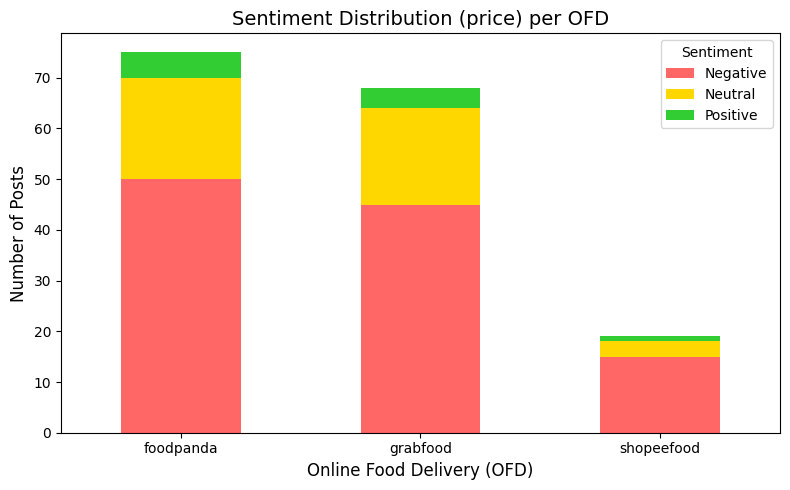

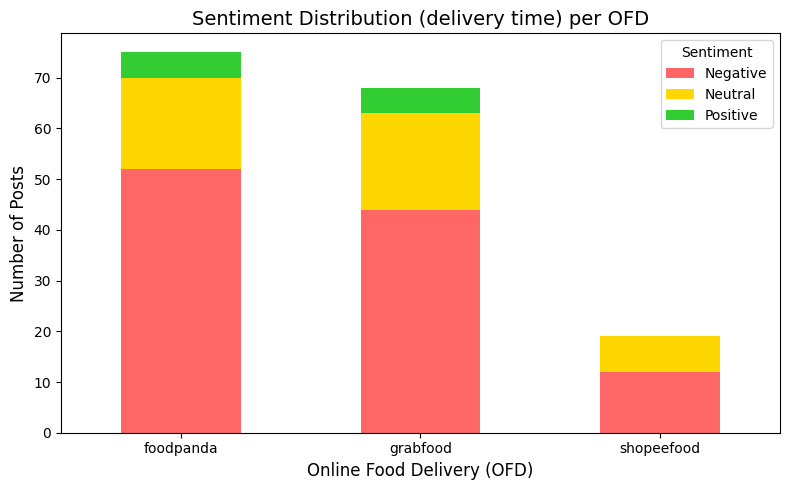

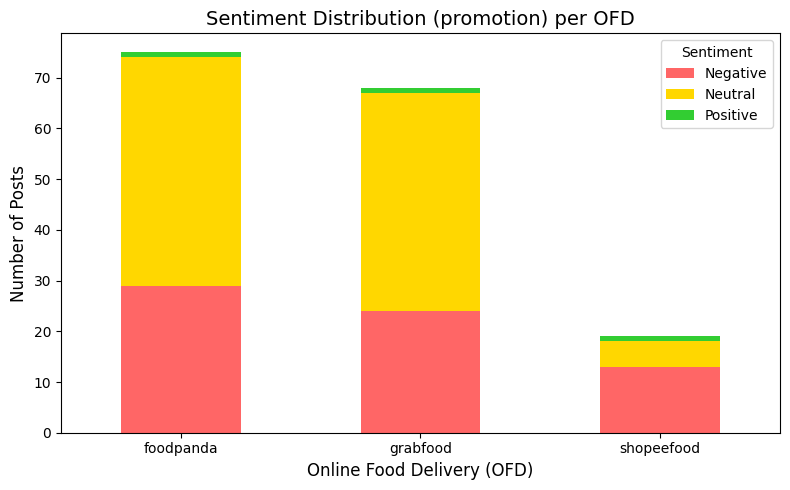

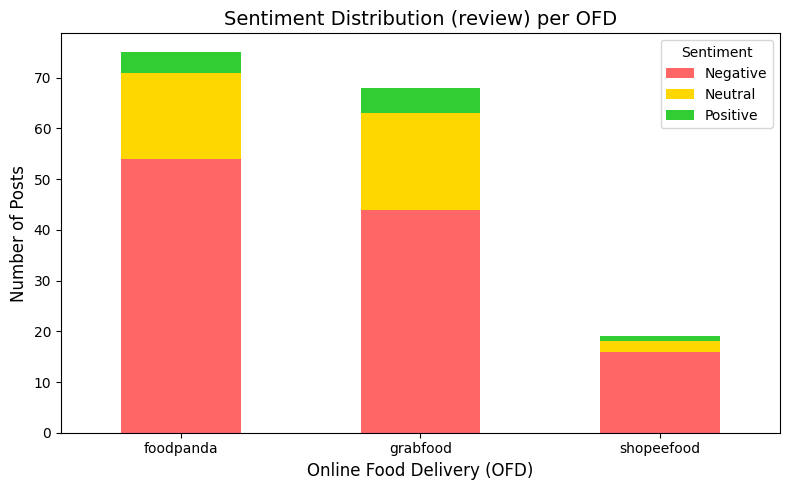

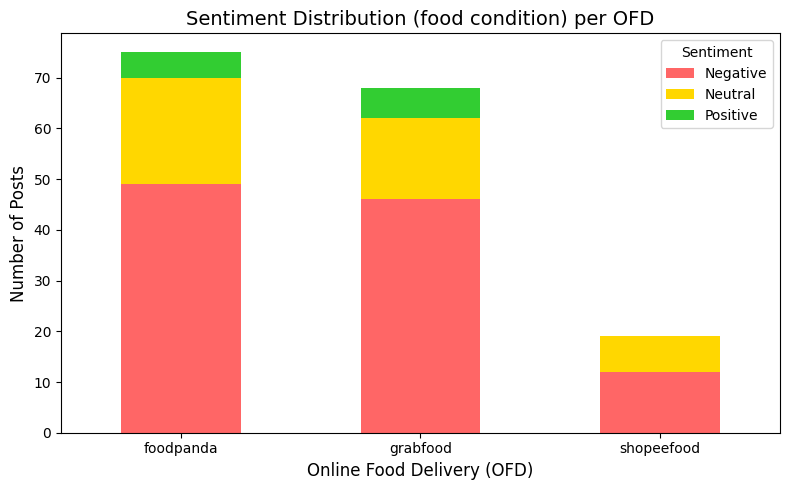

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# List of sentiment aspect columns
aspect_sentiments = [
    'price_sentiment',
    'delivery time_sentiment',
    'promotion_sentiment',
    'review_sentiment',
    'food condition_sentiment'
]

# Bar graph for all aspects
for aspect in aspect_sentiments:
    sentiment_counts = absa_df.groupby(['related_ofd', aspect]).size().unstack(fill_value=0)

    sentiment_counts.plot(kind='bar', stacked=True, figsize=(8,5), color=['#FF6666', '#FFD700', '#32CD32'])
    plt.title(f'Sentiment Distribution ({aspect.replace("_", " ").replace("sentiment", "").strip()}) per OFD', fontsize=14)
    plt.xlabel('Online Food Delivery (OFD)', fontsize=12)
    plt.ylabel('Number of Posts', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()



## Pie Charts – Sentiment Distribution per Aspect

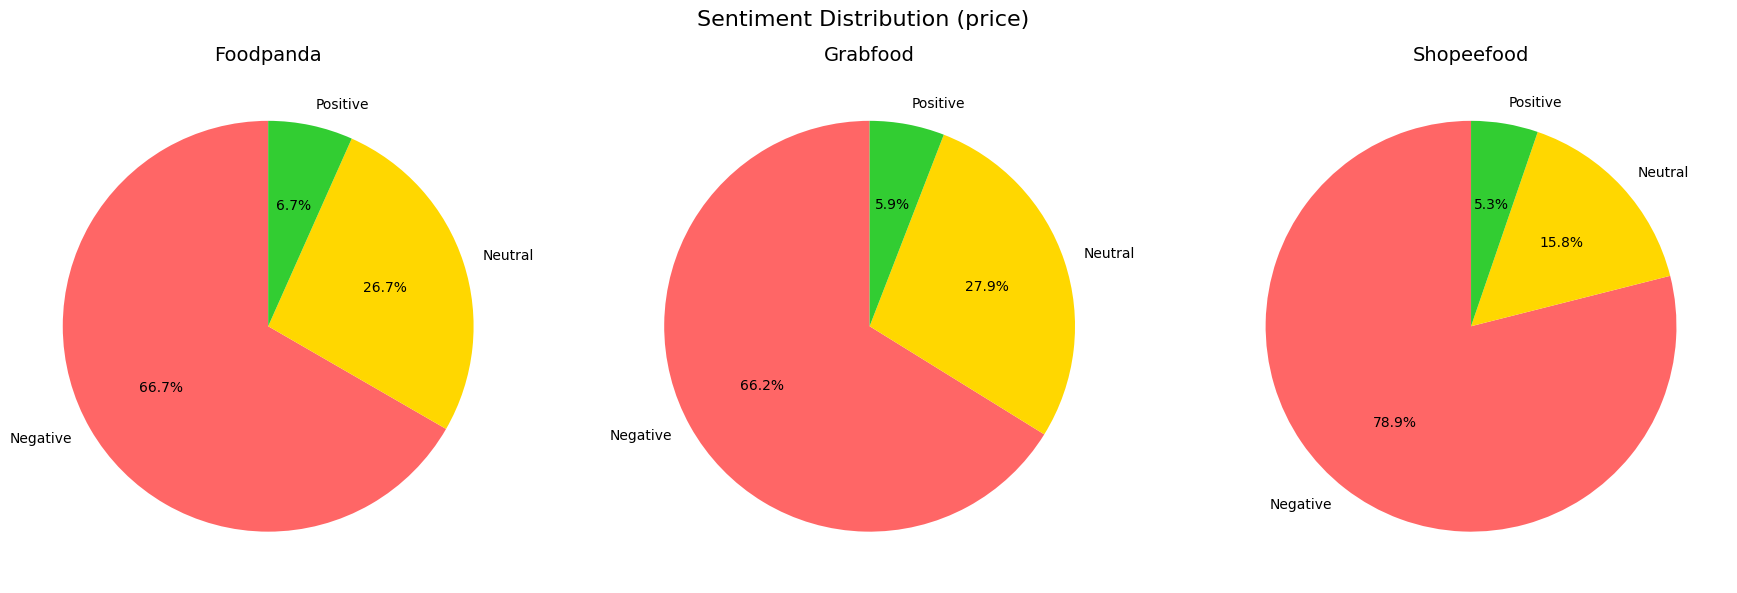

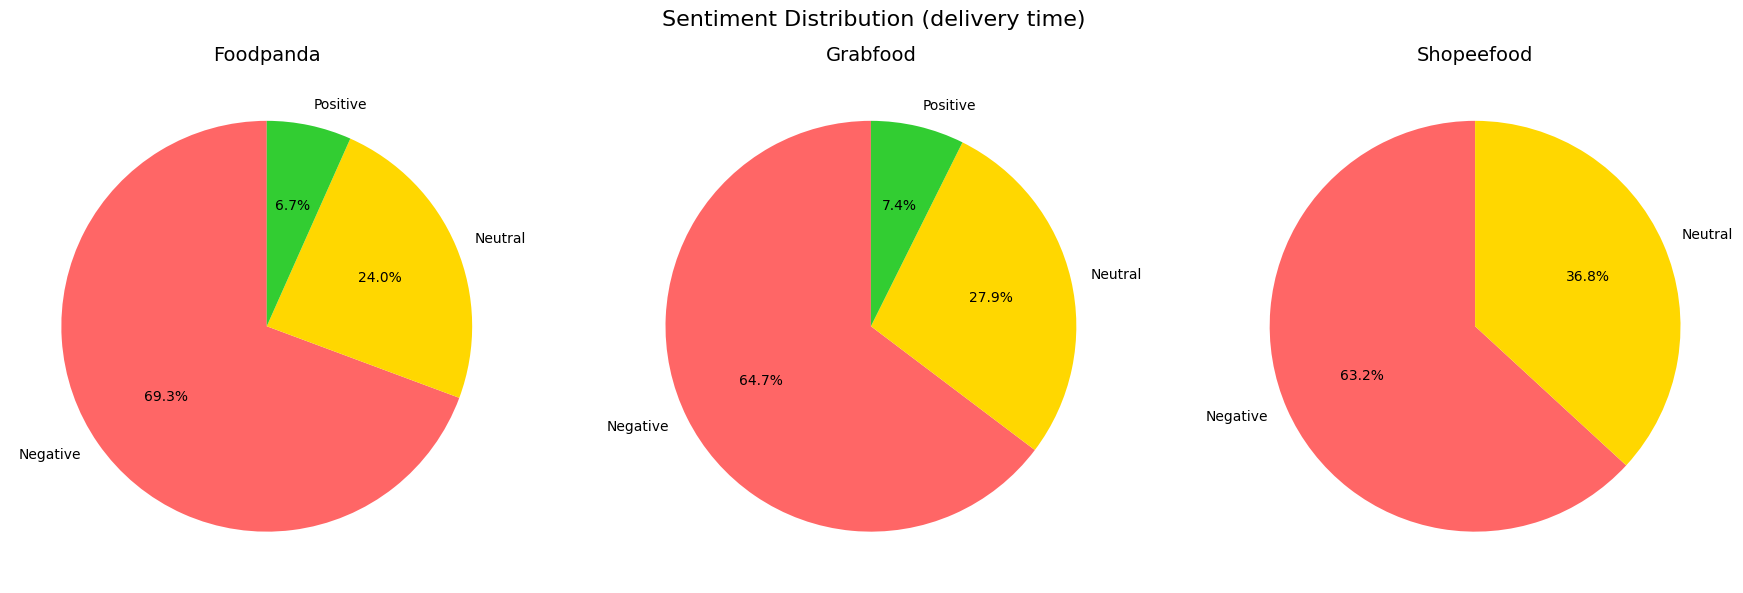

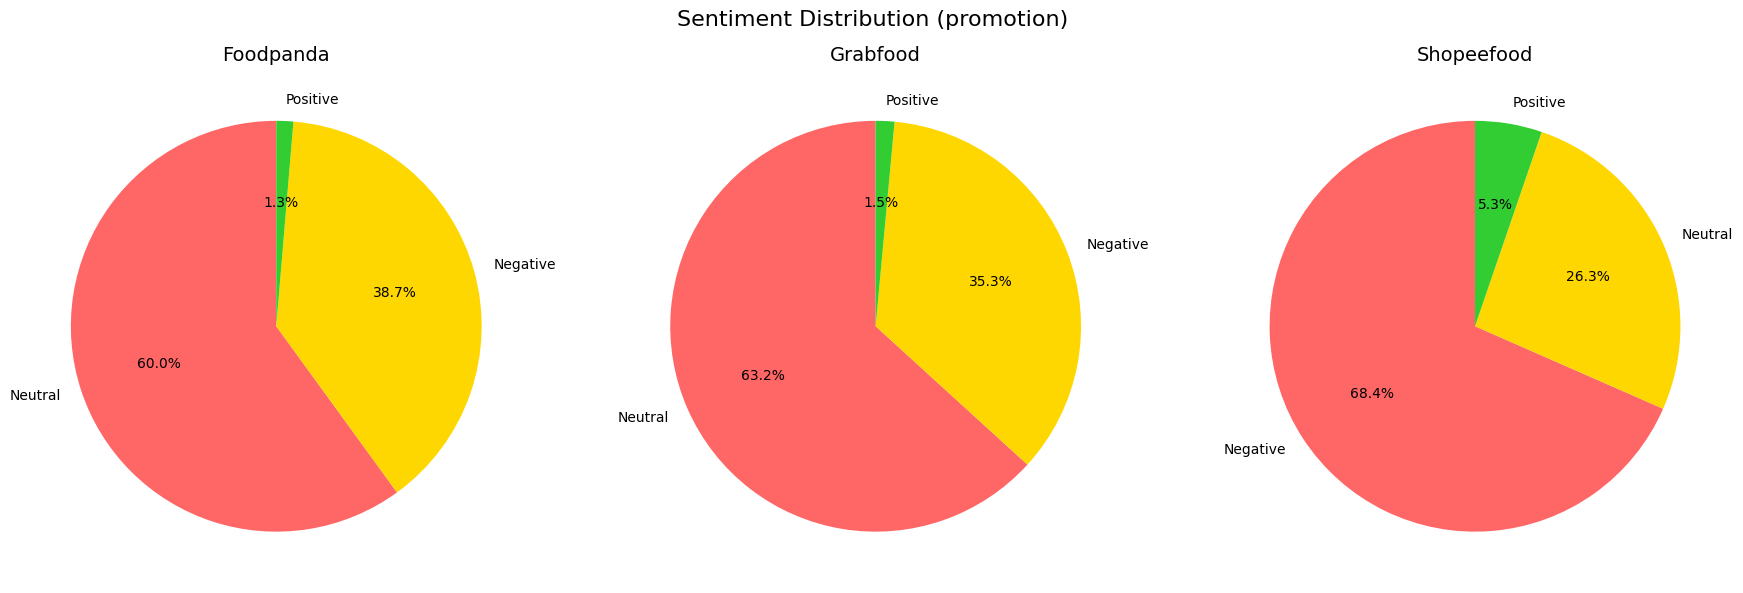

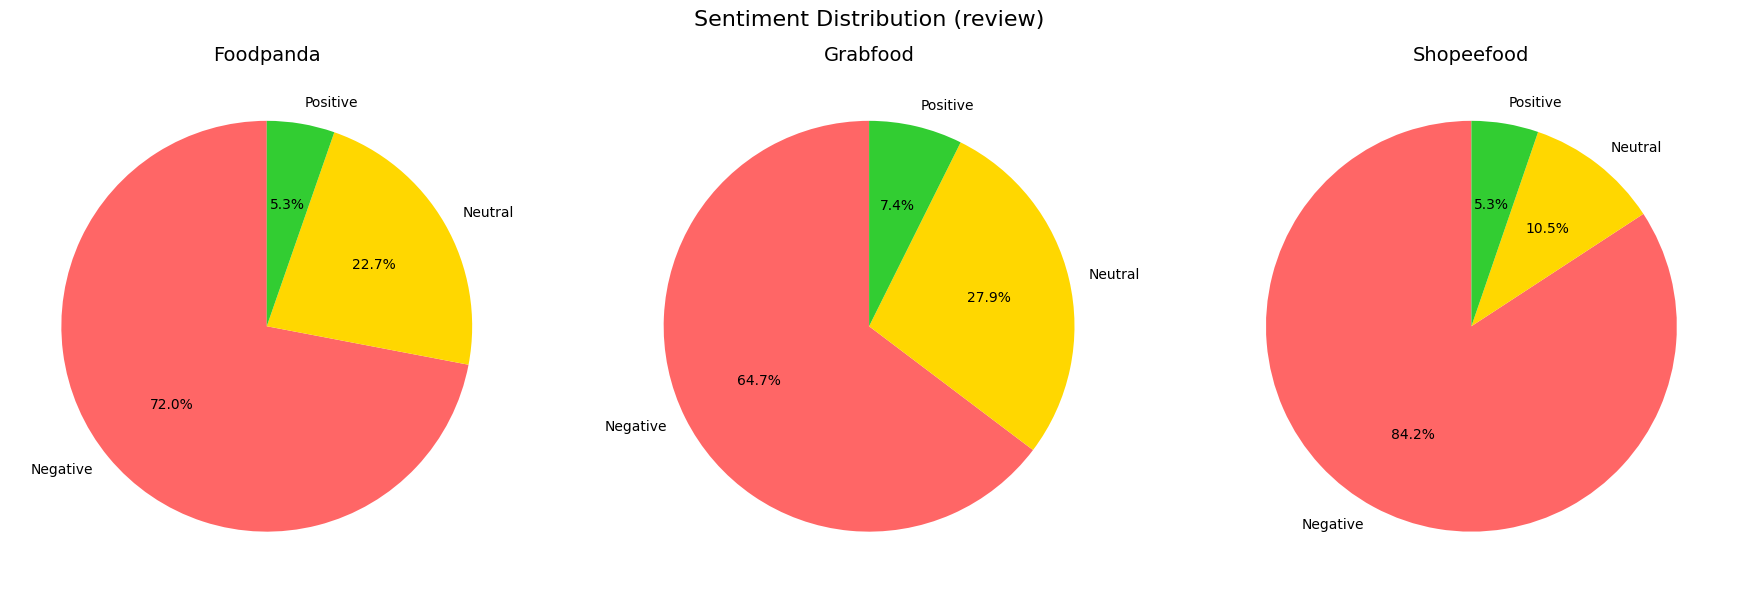

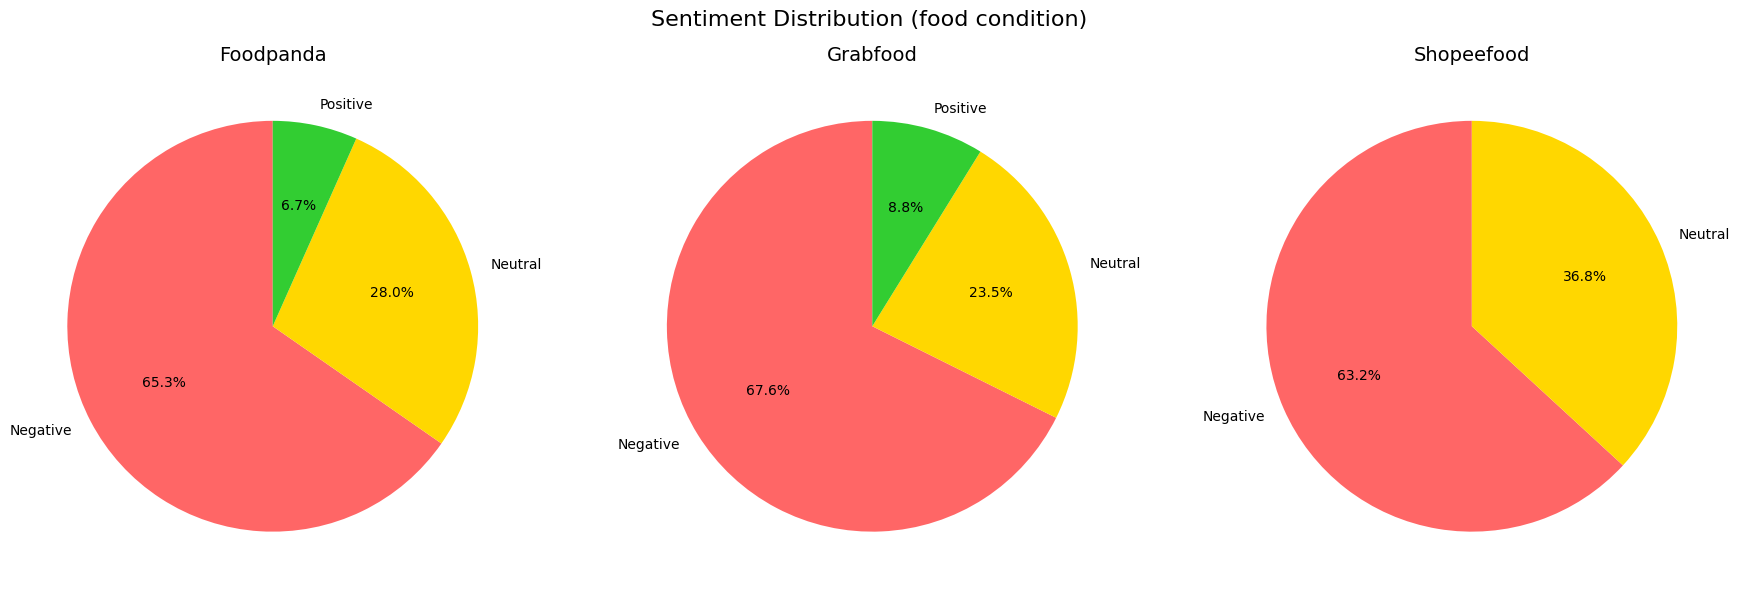

In [24]:
import matplotlib.pyplot as plt

# OFDs and aspects
ofds = ['foodpanda', 'grabfood', 'shopeefood']
aspect_sentiments = [
    'price_sentiment',
    'delivery time_sentiment',
    'promotion_sentiment',
    'review_sentiment',
    'food condition_sentiment'
]

# Generate one figure per aspect (each with 3 subplots)
for aspect in aspect_sentiments:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, ofd in enumerate(ofds):
        ofd_data = absa_df[absa_df['related_ofd'] == ofd]
        sentiment_counts = ofd_data[aspect].value_counts()

        axes[i].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
                    startangle=90, colors=['#FF6666', '#FFD700', '#32CD32'], textprops={'fontsize': 10})
        axes[i].set_title(f'{ofd.capitalize()}', fontsize=14)

    plt.suptitle(f'Sentiment Distribution ({aspect.replace("_", " ").replace("sentiment", "").strip()})', fontsize=16)
    plt.subplots_adjust(top=0.80)
    plt.tight_layout()
    plt.show()



## Word Cloud – Common Words in Posts

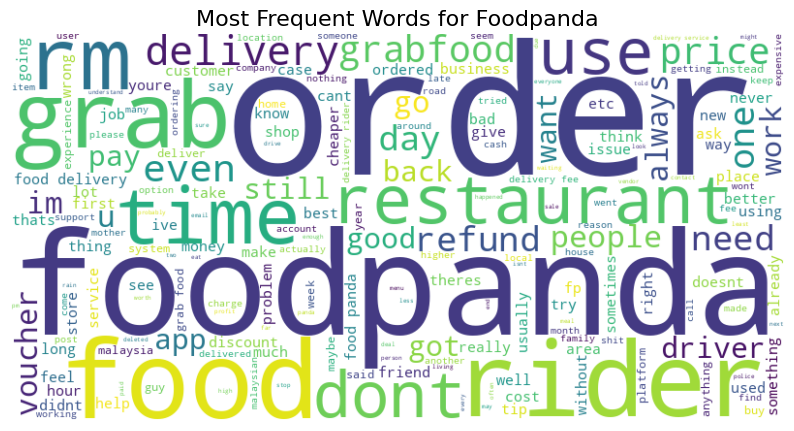

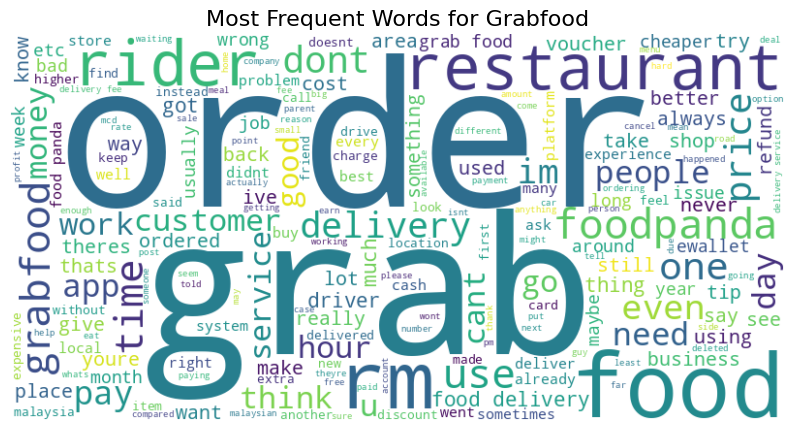

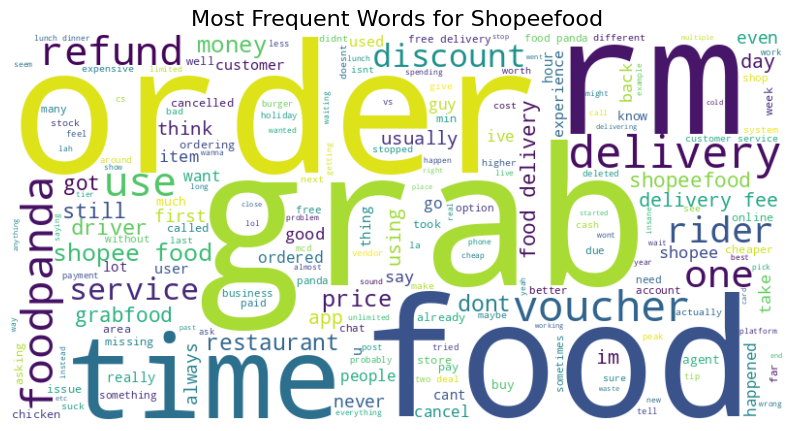

In [25]:
# Word Cloud for each OFD
ofds = ['foodpanda', 'grabfood', 'shopeefood']
for ofd in ofds:
    ofd_data = absa_df[absa_df['related_ofd'] == ofd]
    text = ' '.join(ofd_data['sentence'].dropna())

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Frequent Words for {ofd.capitalize()}', fontsize=16)
    plt.show()

